## Cross validation

Cross validation (CV) is a statistical technique used in machine learning to assess the performance of models. It involves partitioning a dataset into multiple subsets, training the model on some of these subsets, and validating the model on the remaining subsets. 

Cross-validation helps in mitigating overfitting and provides an estimate of the model's generalization performance on unseen data.

Below we will use the "Auto MPG" dataset to demonstrate this concept, whereas we fit more complex models (higher order polynomials with the same feature), and examine the corresponding RMSE (root mean squared error) evaluated on the train and validation dataset.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from typing import Tuple
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle':'--'})

In [2]:
# Define the common functions
def hstack_higher_order(X: np.array, order: int = 1) -> np.array:
    """Construct a matrix with higher order terms."""
    X_raw = X.reshape(-1, 1)
    X_w_higher_orders = np.zeros(shape=(len(X_raw), order))
    for o in range(order):
        X_w_higher_orders[:, o] = np.power(X_raw, o).reshape(1, -1)
    return X_w_higher_orders

def fit_polynomial(
    X: np.array,
    y: np.array,
    order: int = 1,
) -> LinearRegression:
    """Fit a polynomial model to the underlying data."""
    X_fit = hstack_higher_order(X, order)
    # fit the model
    model = LinearRegression()
    model.fit(X_fit, y)
    
    return model

auto = pd.read_csv(
    "https://raw.githubusercontent.com/changyaochen/"
    "MECE4520/master/data/auto_mpg.csv")
auto.dropna(inplace=True)  # Drop the null values
print(f"The shape of the data is {auto.shape}")
auto.head()

The shape of the data is (392, 9)


,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car
0,18.0,8.0,307.0,130.0,3504.0,12.0,70.0,1.0,chevrolet chevelle malibu
1,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,1.0,buick skylark 320
2,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,1.0,plymouth satellite
3,16.0,8.0,304.0,150.0,3433.0,12.0,70.0,1.0,amc rebel sst
4,17.0,8.0,302.0,140.0,3449.0,10.5,70.0,1.0,ford torino


In [3]:
# Fit models with different order polynomials
X = auto["horsepower"].values
y = auto["mpg"].values
n_trials= 10  # we will run multiple trials
max_order = 8

# CV split
# Initialize a pandas dataframe to collect the RMSEs from different trials
rmse = pd.DataFrame(columns=["trial_index", "order", "train", "validation"])
for t in range(n_trials):
    X_train, X_validation, y_train, y_validation = train_test_split(
        X, y, test_size=0.2, random_state=(103 + t)
    )

    # fit different polynomials
    for order in range(1, max_order):
        model = fit_polynomial(X=X_train, y=y_train, order=order)
        y_pred_train = model.predict(hstack_higher_order(X_train, order))
        y_pred_validation = model.predict(hstack_higher_order(X_validation, order))
        row = pd.Series({
            "trial_index": t,
            "order": order,
            "train": mean_squared_error(
                y_true=y_train, y_pred=y_pred_train, squared=False),
            "validation": mean_squared_error(
                y_true=y_validation, y_pred=y_pred_validation, squared=False),
        })
        rmse = pd.concat((rmse, row.to_frame().T), ignore_index=True)

rmse.head()

/var/folders/ck/6xgx96j15vd6tcwzl68twbpc0000gn/T/ipykernel_22789/1191620953.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rmse = pd.concat((rmse, row.to_frame().T), ignore_index=True)


,trial_index,order,train,validation
0,0.0,1.0,7.894118,7.407799
1,0.0,2.0,4.891589,4.904329
2,0.0,3.0,4.279975,4.661947
3,0.0,4.0,4.276973,4.652892
4,0.0,5.0,4.257462,4.698976


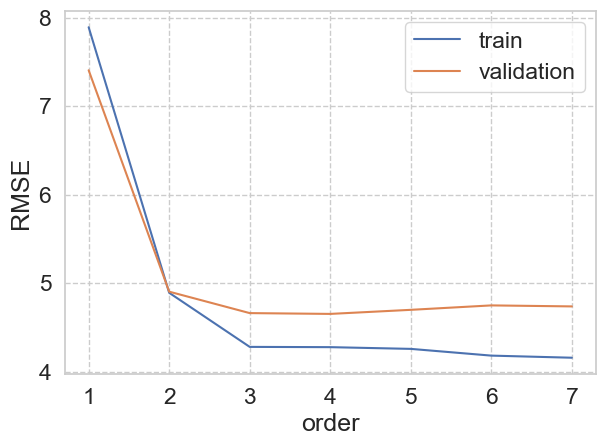

In [4]:
# Plot the RMSE on train and validation dataset
trial_index = 0

plt.figure()
sns.lineplot(x="order", y="train", data=rmse[rmse["trial_index"] == trial_index], label="train")
sns.lineplot(x="order", y="validation", data=rmse[rmse["trial_index"] == trial_index], label="validation")

plt.gca().set_ylabel("RMSE")
plt.tight_layout()
plt.show()

The train-validation split is essentially random, therefore, the error metrics (RMSE) evaluated on them are random variables. Here we want to demonstrate the variance of the validation metrics from different train-validation splits.

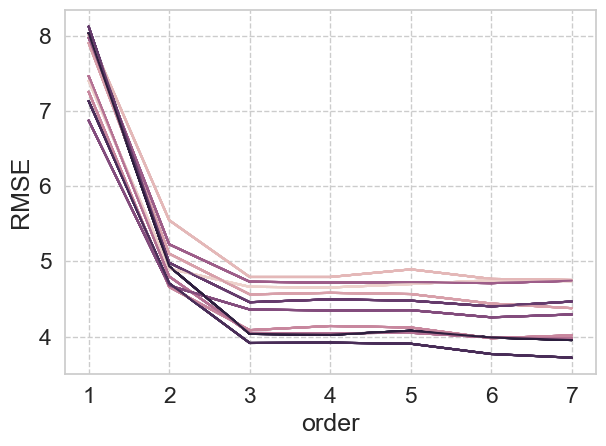

In [5]:
plt.figure()
for t in range(n_trials):
    sns.lineplot(x="order", y="validation", data=rmse, hue="trial_index")

plt.gca().set_ylabel("RMSE")
plt.gca().get_legend().remove()
plt.tight_layout()
plt.show()